### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo. 

El dataset con el que vamos a trabajar en este notebook contiene un total de **426 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**MENSUALES**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
3. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
4. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
5. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

<a id='index'></a>
### Índice

[Imports del notebook](#imports_notebook)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [105]:
import os

import pandas as pd
import xgboost as xgb

In [106]:
print(f"pandas version: {pd.__version__}")
print(f"xgboost version: {xgb.__version__}")

pandas version: 2.2.3
xgboost version: 2.1.3


In [107]:
# if pd.__version__ != "1.5.1":
#     os.system("pip install pandas==1.5.1")

In [108]:
# if xgb.__version__ != "1.3.3":
#     os.system("pip install xgboost==1.3.3")

In [109]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [110]:
# from google.colab import drive
# drive.mount('/content/drive')

In [111]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.26.4
Pandas version 2.2.3
XGBoost version 2.1.3


In [112]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

# DATA_PATH = ""

FILE_NAME = "ts_kaggle_train.csv"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, FILE_NAME)

<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comenzar con el EDA.

In [113]:
df = pd.read_csv(TRAIN_CSV_PATH, index_col = 0)
df.sample(5)

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
7703,2015-04-30,31_12551,7,31,55,12551,199.0,7.0
11147,2015-02-28,52_7856,18,52,28,7856,NaN,0.0
3613,2014-02-28,25_14842,7,25,65,14842,199.0,13.0
8938,2015-09-30,3_5822,0,3,35,5822,1149.0,5.0
3766,2014-06-30,25_16169,7,25,65,16169,299.0,9.0


Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   14484 non-null  object 
 1   unique_id              14484 non-null  object 
 2   city_id                14484 non-null  int64  
 3   shop_id                14484 non-null  int64  
 4   item_category_id       14484 non-null  int64  
 5   item_id                14484 non-null  int64  
 6   monthly_average_price  13262 non-null  float64
 7   monthly_sales          13756 non-null  float64
dtypes: float64(2), int64(4), object(2)
memory usage: 1018.4+ KB


In [115]:
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

<a id='benchmark'></a>
### La idea del Benchmark (CORE IDEA)
[Volver al índice](#index)

En el presente notebook buscamos establecer un benchmark rápido. 

El motivo fundamental es porque los datasets en la vida real son muy complejos y no tenemos el "lujo" de poder analizar todas y cada una de las variables <u>**ANTES DE ENTRENAR NUESTRO PRIMER MODELO.</u>**

Establecer un benchmark nos ayuda a entender cual es el punto de partida, es decir: <u>**cual es el score mínimo para este dataset.**</u>

Muchas veces este benchmark puede ser un modelo entrenado con unas pocas columnas númericas (imputando los nulos con la media). <u>**No se trata de tener el mejor modelo sino de entrenar nuestro primer modelo.**</u> 

Una vez sabemos cual es el punto de partida y tenemos un notebook **"funcional"** podemos empezar a experimentar con nuestro dataset. Por **"notebook funcional"** entendemos un script/notebook que podemos ejecutar en su totalidad (loading del dataset, preprocessing, train_test_split, train y predict). En cada experimento iremos añadiendo nuevas variables, diferentes imputaciones, modelos y vamos guardando el score que obtenemos. De este manera, podemos ver la contribución de cada variables y comprobar si estamos mejorando o no respecto al benchmark.

Dado que este notebook es un benchmark, tenemos que **"acotar"** muy bien las cosas que vamos a implementar (para no irnos por las ramas).

A **grosso modo** vamos a hacer las siguientes cosas:

1. Tratar los nulos.
1. Realizar un pequeño EDA sobre el dataset.
1. Crear algunas variables rápidas para el entrenamiento.
1. Entrenar el algoritmo.
1. Evaluar el modelo.
1. Hacer el submit a Kaggle.

Empecemos:

Tenemos un total de 426 Series Temporales en el dataset:

In [116]:
df["unique_id"].nunique()

426

Veamos cuales son las fechas min y max de nuestro dataset:

In [117]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()

In [118]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [119]:
df.isnull().sum()

date                        0
unique_id                   0
city_id                     0
shop_id                     0
item_category_id            0
item_id                     0
monthly_average_price    1222
monthly_sales             728
dtype: int64

<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [120]:
sample_ts = "31_4249"

In [121]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [122]:
df.fillna({"monthly_sales":0}, inplace = True)

#entendemos que los nulos es porque no ha habido ventas y por tanto es 0

In [123]:
df["monthly_average_price"] = df.groupby("unique_id", group_keys = False)["monthly_average_price"].apply(
    lambda series: series.bfill().ffill()
)

#rellenar los valores faltantes (NaN) en la columna monthly_average_price de cada grupo de unique_id usando un enfoque combinado 
# de backfill (rellenar con valores posteriores) y forward fill (rellenar con valores anteriores).

In [124]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [125]:
df.sort_values(["unique_id", "date"], ascending = True, inplace = True)

#Este código ordena el DataFrame df por las columnas unique_id y date en orden ascendente (True)

In [126]:
df[df["unique_id"] == sample_ts]

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
5666,2013-01-31,31_4249,7,31,23,4249,1899.000000,2.0
5743,2013-02-28,31_4249,7,31,23,4249,1599.000000,5.0
5820,2013-03-31,31_4249,7,31,23,4249,1013.416000,6.0
5897,2013-04-30,31_4249,7,31,23,4249,1598.900000,10.0
5974,2013-05-31,31_4249,7,31,23,4249,1598.937500,8.0
6051,2013-06-30,31_4249,7,31,23,4249,1599.000000,4.0
6128,2013-07-31,31_4249,7,31,23,4249,1399.000000,4.0
6205,2013-08-31,31_4249,7,31,23,4249,1599.000000,2.0
6282,2013-09-30,31_4249,7,31,23,4249,1199.000000,5.0
6359,2013-10-31,31_4249,7,31,23,4249,929.075000,4.0


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   14484 non-null  datetime64[ns]
 1   unique_id              14484 non-null  object        
 2   city_id                14484 non-null  int64         
 3   shop_id                14484 non-null  int64         
 4   item_category_id       14484 non-null  int64         
 5   item_id                14484 non-null  int64         
 6   monthly_average_price  14484 non-null  float64       
 7   monthly_sales          14484 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [128]:
df.isnull().sum()

date                     0
unique_id                0
city_id                  0
shop_id                  0
item_category_id         0
item_id                  0
monthly_average_price    0
monthly_sales            0
dtype: int64

In [129]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
...,...,...,...,...,...,...,...,...
14435,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0
14447,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0
14459,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0
14471,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0


<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

Al tratarse este notebook del benchmark, vamos a explorar de manera muy superficial el dataset. En posteriores ejecuciones analizaremos el dataset en más detalle, construiremos nuevas variables y volveremos a entrenar nuestro modelo.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

In [130]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 14)
    plot_pacf(x = y, ax = ax3, lags = 14)

    plt.suptitle(t = title, fontsize = 20)

In [131]:
y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre

/var/folders/8g/crnc9k7n5l7dzzv7nvvslql00000gp/T/ipykernel_14632/3920371324.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = df.set_index("date").resample("M")["monthly_sales"].sum()[:-1] # quitamos los registros de octubre


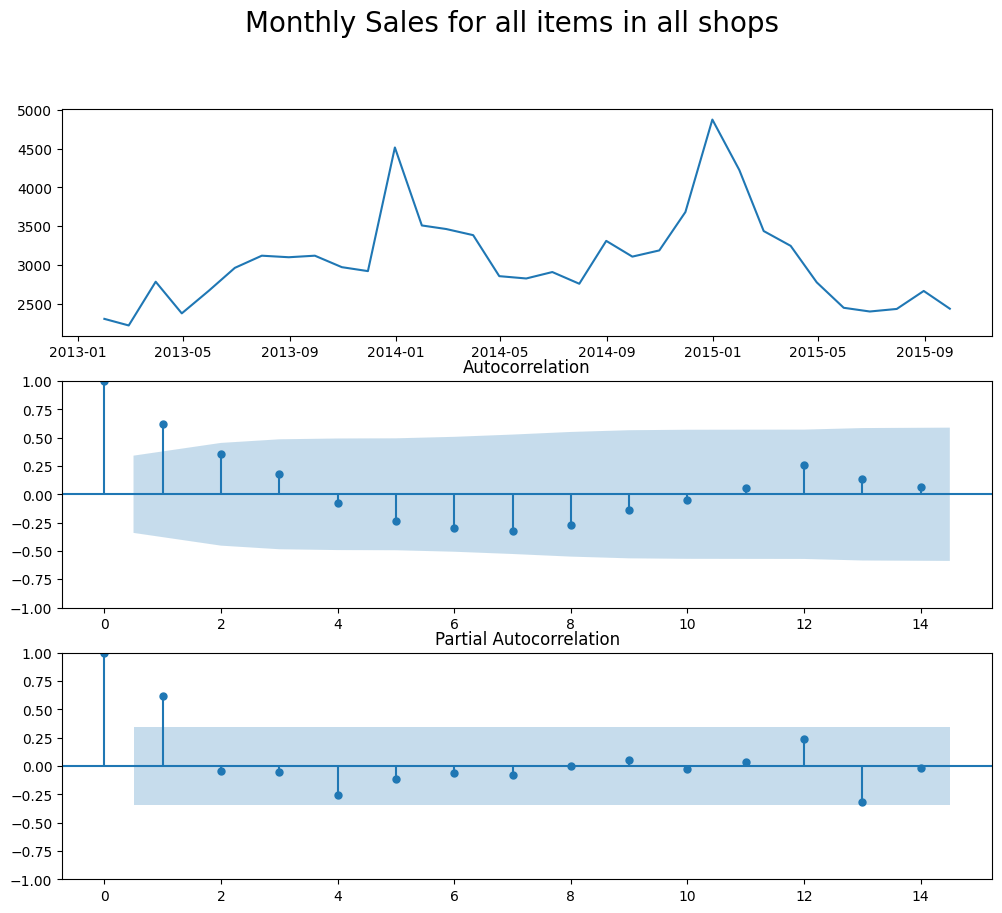

In [132]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Nota importante: nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: más de 400 Series Temporales diferentes tendríamos que entrenar 400 ARIMAs (1 modelo por Serie Temporal). En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

IDEA para los alumnos: podéis intentar analizar algunas de las 400 Series Temporales de manera individual para ver su comportamiento.

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

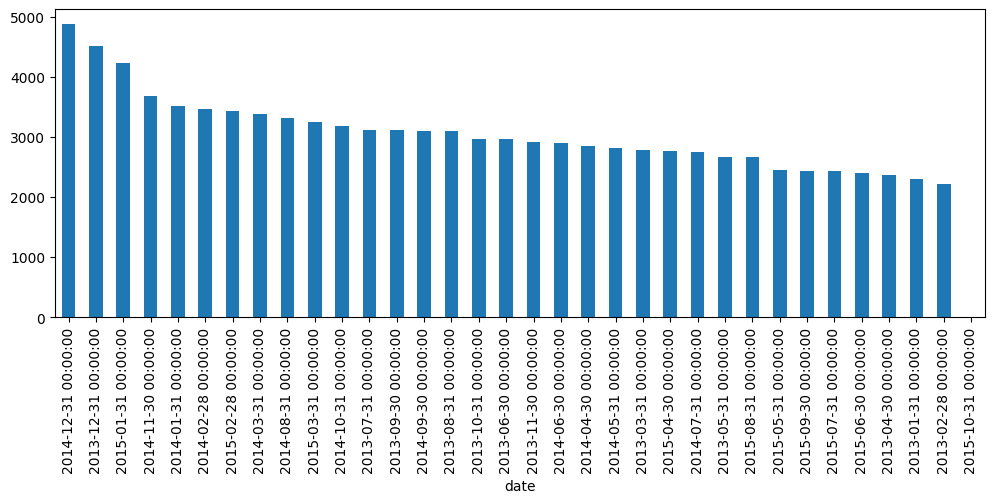

In [133]:
(
    df.
    groupby(["date"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

In [134]:
df.groupby(["date"])["monthly_sales"].sum().sort_values()
   


date
2015-10-31       0.0
2013-02-28    2218.0
2013-01-31    2303.0
2013-04-30    2374.0
2015-06-30    2398.0
2015-07-31    2431.0
2015-09-30    2434.0
2015-05-31    2446.0
2015-08-31    2663.0
2013-05-31    2665.0
2014-07-31    2756.0
2015-04-30    2774.0
2013-03-31    2782.0
2014-05-31    2824.0
2014-04-30    2854.0
2014-06-30    2907.0
2013-11-30    2919.0
2013-06-30    2961.0
2013-10-31    2970.0
2013-08-31    3098.0
2014-09-30    3106.0
2013-09-30    3118.0
2013-07-31    3118.0
2014-10-31    3186.0
2015-03-31    3245.0
2014-08-31    3309.0
2014-03-31    3383.0
2015-02-28    3436.0
2014-02-28    3462.0
2014-01-31    3508.0
2014-11-30    3681.0
2015-01-31    4223.0
2013-12-31    4514.0
2014-12-31    4874.0
Name: monthly_sales, dtype: float64

In [135]:
df.groupby(["item_category_id"])["item_id"].nunique().sort_values()


item_category_id
2      1
76     1
71     1
69     1
57     1
79     1
38     1
41     1
21     1
22     1
28     2
54     2
83     2
64     3
19     3
6      3
35     4
9      4
73     4
23     5
75     5
31     6
63     7
65     8
49     9
30    12
55    19
40    24
Name: item_id, dtype: int64

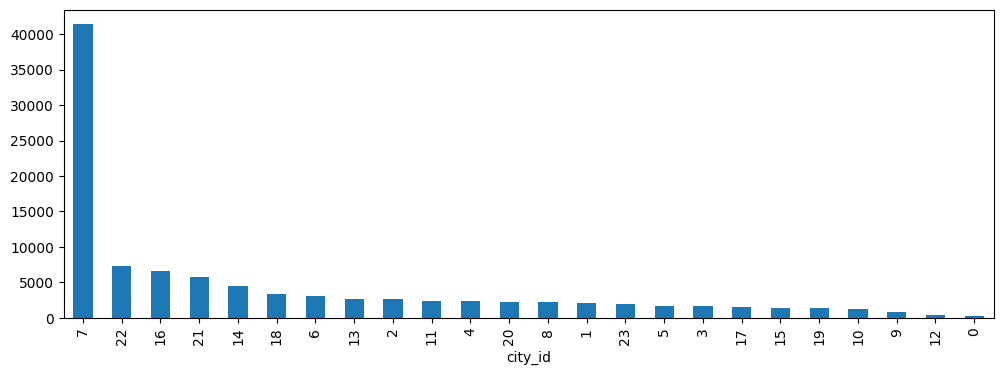

In [136]:
(
    df.
    groupby(["city_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

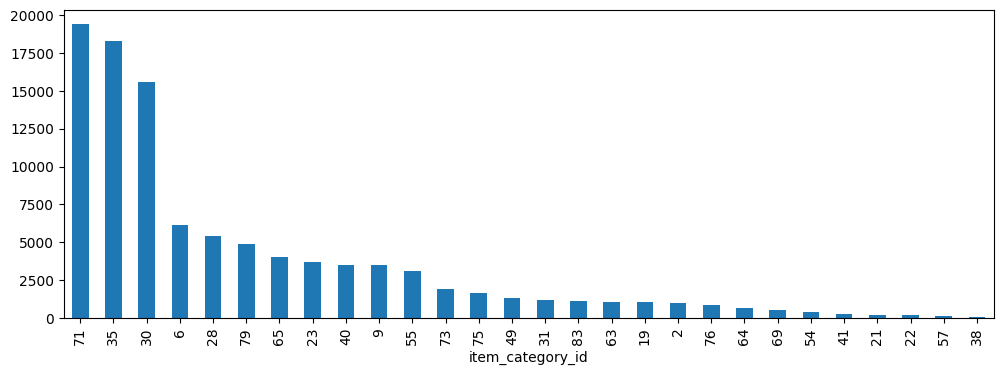

In [137]:
(
    df.
    groupby(["item_category_id"])
    ["monthly_sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo el código encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene más de 400 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [138]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
...,...,...,...,...,...,...,...,...
14435,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0
14447,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0
14459,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0
14471,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0


In [141]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,date_quarter,quarter_sin,quarter_cos
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,1,1.000000e+00,6.123234e-17
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,1,1.000000e+00,6.123234e-17
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,1,1.000000e+00,6.123234e-17
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,2,1.224647e-16,-1.000000e+00
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,2,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
14435,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0,2,1.224647e-16,-1.000000e+00
14447,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0,3,-1.000000e+00,-1.836970e-16
14459,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0,3,-1.000000e+00,-1.836970e-16
14471,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0,3,-1.000000e+00,-1.836970e-16


In [142]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name, nr_lags):
    
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("M")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
     
    for lag in range(nr_lags):
        gb_df_[f"{new_name}_lag{lag + 1}"] = gb_df_.groupby(gb_list)[new_name].transform(
            lambda series: series.shift(lag + 1)
        )
    
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)
    
    return gb_df_

In [143]:
vars_item_id = build_ts_vars(
    df = df,
    gb_list = ["item_id"],
    target_column = "monthly_sales",
    agg_func = np.sum,
    agg_func_name =  "sum",
    nr_lags = 3
    
)

vars_shop_item_revenue = build_ts_vars(
    df = df,
    gb_list = ["shop_id", "item_id"],
    target_column = "revenue",
    agg_func = np.sum,
    agg_func_name =  "sum",
    nr_lags = 3
    
)

Dropping columns that might cause target leakage item_id_monthly_sales_sum


/var/folders/8g/crnc9k7n5l7dzzv7nvvslql00000gp/T/ipykernel_14632/2211386838.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")[target_column]
/var/folders/8g/crnc9k7n5l7dzzv7nvvslql00000gp/T/ipykernel_14632/2211386838.py:12: FutureWarning: The provided callable <function sum at 0x1066dc360> is currently using DatetimeIndexResamplerGroupby.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .apply(agg_func)
/var/folders/8g/crnc9k7n5l7dzzv7nvvslql00000gp/T/ipykernel_14632/2211386838.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")[target_column]


KeyError: 'Column not found: revenue'

In [258]:
vars_item_id

,item_id,date,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3
0,32,2013-01-31,NaN,NaN,NaN
1,32,2013-02-28,24.0,NaN,NaN
2,32,2013-03-31,20.0,24.0,NaN
3,32,2013-04-30,13.0,20.0,24.0
4,32,2013-05-31,11.0,13.0,20.0
...,...,...,...,...,...
4483,22088,2015-06-30,17.0,13.0,14.0
4484,22088,2015-07-31,10.0,17.0,13.0
4485,22088,2015-08-31,20.0,10.0,17.0
4486,22088,2015-09-30,24.0,20.0,10.0


In [259]:
vars_shop_item_revenue

,shop_id,item_id,date,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3
0,3,5822,2013-01-31,NaN,NaN,NaN
1,3,5822,2013-02-28,999.0,NaN,NaN
2,3,5822,2013-03-31,999.0,999.0,NaN
3,3,5822,2013-04-30,1049.0,999.0,999.0
4,3,5822,2013-05-31,1048.5,1049.0,999.0
...,...,...,...,...,...,...
14479,59,22088,2015-06-30,357.0,357.0,476.0
14480,59,22088,2015-07-31,476.0,357.0,357.0
14481,59,22088,2015-08-31,833.0,476.0,357.0
14482,59,22088,2015-09-30,833.0,833.0,476.0


<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

In [260]:
print(df.shape)

df = pd.merge(df, vars_item_id, on = ["date", "item_id"], how = "left")
df = pd.merge(df, vars_shop_item_revenue, on = ["date", "shop_id", "item_id"], how = "left")

print(df.shape)

(14484, 9)
(14484, 15)


In [261]:
df

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,30.0,NaN,NaN,45345.378788,NaN,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,27.0,30.0,NaN,41394.375000,45345.378788,NaN
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,30.0,27.0,30.0,97574.107143,41394.375000,45345.378788
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,27.0,30.0,27.0,42943.909091,97574.107143,41394.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14479,2015-06-30,7_7893,21,7,6,7893,2490.000000,1.0,2490.000000,28.0,28.0,40.0,8520.000000,5780.000000,11826.666667
14480,2015-07-31,7_7893,21,7,6,7893,2690.000000,1.0,2690.000000,43.0,28.0,28.0,2490.000000,8520.000000,5780.000000
14481,2015-08-31,7_7893,21,7,6,7893,2490.000000,1.0,2490.000000,37.0,43.0,28.0,2690.000000,2490.000000,8520.000000
14482,2015-09-30,7_7893,21,7,6,7893,2689.900000,5.0,13449.500000,38.0,37.0,43.0,2490.000000,2690.000000,2490.000000


# ENTRENAMOS SIEMPRE CON EL PASADO

In [262]:
df.head()

,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,revenue,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,45345.378788,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,41394.375000,30.0,NaN,NaN,45345.378788,NaN,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,97574.107143,27.0,30.0,NaN,41394.375000,45345.378788,NaN
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,42943.909091,30.0,27.0,30.0,97574.107143,41394.375000,45345.378788
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,43425.937500,27.0,30.0,27.0,42943.909091,97574.107143,41394.375000


<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [263]:
df.columns.tolist()

['date',
 'unique_id',
 'city_id',
 'shop_id',
 'item_category_id',
 'item_id',
 'monthly_average_price',
 'monthly_sales',
 'revenue',
 'item_id_monthly_sales_sum_lag1',
 'item_id_monthly_sales_sum_lag2',
 'item_id_monthly_sales_sum_lag3',
 'shop_id_item_id_revenue_sum_lag1',
 'shop_id_item_id_revenue_sum_lag2',
 'shop_id_item_id_revenue_sum_lag3']

In [264]:
COLUMNS_TO_DROP = [
    "revenue"
]

df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [265]:
df.set_index("unique_id", inplace = True)

In [267]:
df

,date,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3
unique_id,,,,,,,,,,,,,
12_11365,2013-01-31,16,12,9,11365,1511.512626,30.0,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,2013-02-28,16,12,9,11365,1533.125000,27.0,30.0,NaN,NaN,45345.378788,NaN,NaN
12_11365,2013-03-31,16,12,9,11365,3252.470238,30.0,27.0,30.0,NaN,41394.375000,45345.378788,NaN
12_11365,2013-04-30,16,12,9,11365,1590.515152,27.0,30.0,27.0,30.0,97574.107143,41394.375000,45345.378788
12_11365,2013-05-31,16,12,9,11365,1447.531250,30.0,27.0,30.0,27.0,42943.909091,97574.107143,41394.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7_7893,2015-06-30,21,7,6,7893,2490.000000,1.0,28.0,28.0,40.0,8520.000000,5780.000000,11826.666667
7_7893,2015-07-31,21,7,6,7893,2690.000000,1.0,43.0,28.0,28.0,2490.000000,8520.000000,5780.000000
7_7893,2015-08-31,21,7,6,7893,2490.000000,1.0,37.0,43.0,28.0,2690.000000,2490.000000,8520.000000


In [41]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

In [42]:
print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



In [43]:
X_train = df[df["date"].isin(train_index)].drop(['monthly_sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['monthly_sales']

X_valida = df[df["date"].isin(valida_index)].drop(['monthly_sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['monthly_sales']

X_test = df[df["date"].isin(test_index)].drop(['monthly_sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['monthly_sales']

In [44]:
X_train.head(3)

,city_id,shop_id,item_category_id,item_id,monthly_average_price,item_id_monthly_sales_sum_lag1,item_id_monthly_sales_sum_lag2,item_id_monthly_sales_sum_lag3,shop_id_item_id_revenue_sum_lag1,shop_id_item_id_revenue_sum_lag2,shop_id_item_id_revenue_sum_lag3
unique_id,,,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,NaN,NaN,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1533.125000,30.0,NaN,NaN,45345.378788,NaN,NaN
12_11365,16,12,9,11365,3252.470238,27.0,30.0,NaN,41394.375000,45345.378788,NaN


In [45]:
Y_train.head(3)

unique_id
12_11365    30.0
12_11365    27.0
12_11365    30.0
Name: monthly_sales, dtype: float64

<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [46]:
# max_depth
# n_estimators
# early_stopping_rounds

model = xgb.XGBRegressor(max_depth = 5, eval_metric = "rmse", seed = 175)

model.fit(
    X_train,
    Y_train,
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
    verbose = True
)

[0]	validation_0-rmse:6.45801	validation_1-rmse:5.91495
[1]	validation_0-rmse:5.52981	validation_1-rmse:4.91565
[2]	validation_0-rmse:4.97838	validation_1-rmse:4.24127
[3]	validation_0-rmse:4.62446	validation_1-rmse:3.82096
[4]	validation_0-rmse:4.41857	validation_1-rmse:3.59060
[5]	validation_0-rmse:4.28438	validation_1-rmse:3.41822
[6]	validation_0-rmse:4.18355	validation_1-rmse:3.28547
[7]	validation_0-rmse:4.07790	validation_1-rmse:3.21069
[8]	validation_0-rmse:4.02417	validation_1-rmse:3.18106
[9]	validation_0-rmse:3.97930	validation_1-rmse:3.15179
[10]	validation_0-rmse:3.93802	validation_1-rmse:3.11466
[11]	validation_0-rmse:3.89841	validation_1-rmse:3.09346
[12]	validation_0-rmse:3.86060	validation_1-rmse:3.03589
[13]	validation_0-rmse:3.80784	validation_1-rmse:3.03896
[14]	validation_0-rmse:3.78316	validation_1-rmse:3.01830
[15]	validation_0-rmse:3.74742	validation_1-rmse:3.01542
[16]	validation_0-rmse:3.71301	validation_1-rmse:3.00540
[17]	validation_0-rmse:3.69500	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

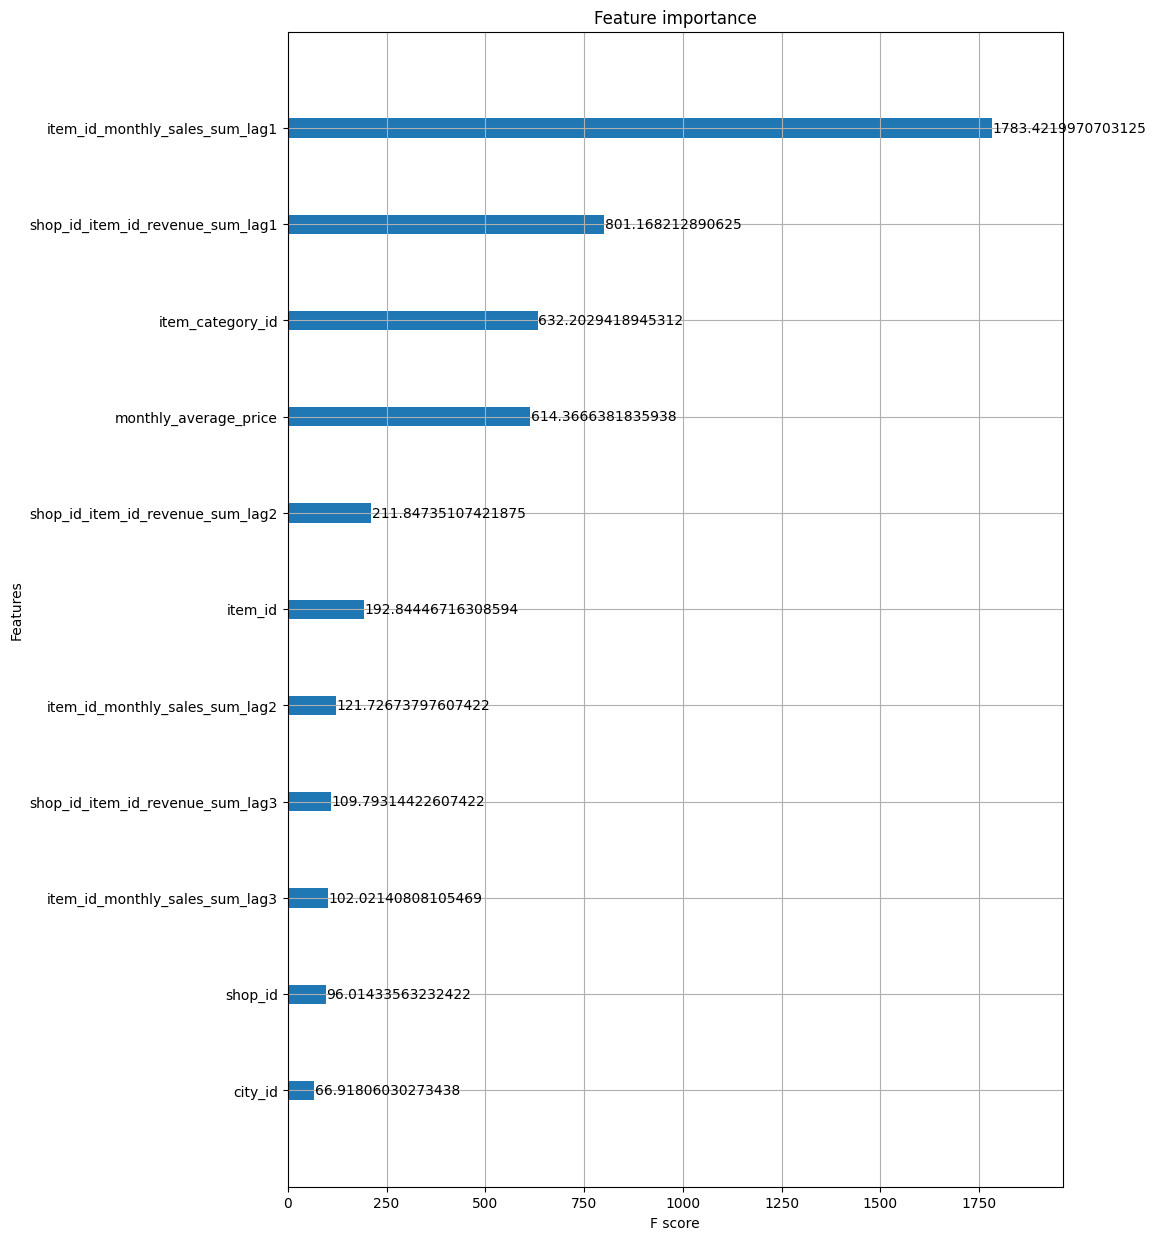

In [47]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [48]:
if "monthly_sales" in X_test.columns:
    X_test.drop("monthly_sales", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

In [49]:
X_test.reset_index(inplace = True)

In [50]:
Y_train_predict = model.predict(X_train)
Y_valida_predict = model.predict(X_valida)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [51]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 2_812
Validation RMSE: 2_874


In [52]:
(
###    X_test[["unique_id", "monthly_sales"]]
   ### .to_csv(f"/Users/casports/Library/CloudStorage/GoogleDrive-albert.fdez95@gmail.com/Mi unidad/NUCLIO_DS_2425/03. MODULOS/M4 - Machine Learning/Clase 9 - Time Series/submissions/submission_train_{rmse_train}_valida_{rmse_valida}.csv", index = False)
)

()

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
1. Construir nuevas variables.
1. Probar estas variables en el modelo.
1. Guardar el score para ver la mejora o no (Kaggle Submit).
1. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
1. Darle más profundidad a los lags/shifts.
1. Implementar medias móviles (ojo variables autoexplicativas).
1. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
1. Probar otros algoritmos.
1. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)